In [16]:
import numpy as np
import pandas as pd
import random

chips_dataset = pd.read_csv("data/chips.csv")
geyser_dataset = pd.read_csv("data/geyser.csv")

print(chips_dataset)
print(geyser_dataset)

            x         y class
0    0.051267  0.699560     P
1   -0.092742  0.684940     P
2   -0.213710  0.692250     P
3   -0.375000  0.502190     P
4   -0.513250  0.465640     P
..        ...       ...   ...
113 -0.720620  0.538740     N
114 -0.593890  0.494880     N
115 -0.484450  0.999270     N
116 -0.006336  0.999270     N
117  0.632650 -0.030612     N

[118 rows x 3 columns]
      x    y class
0     1  4.4     N
1     1  3.9     N
2     1  4.0     P
3     1  4.0     N
4     1  3.5     N
..   ..  ...   ...
217  23  2.1     P
218  23  4.2     N
219  23  2.1     P
220  23  5.2     N
221  23  2.0     P

[222 rows x 3 columns]


In [17]:
def normalize(y):
    return np.fromiter(map(lambda s: 1 if s == "P" else -1, y), dtype=float)

x_chips = chips_dataset.drop(["class"], axis=1).to_numpy(dtype=float)
y_chips = normalize(chips_dataset["class"].to_numpy())

x_geyser = geyser_dataset.drop(["class"], axis=1).to_numpy(dtype=float)
y_geyser = normalize(geyser_dataset["class"].to_numpy())

In [18]:
def linear_kernel(x, y):
    return np.dot(x, y)

def polynomial_kernel(d, x, y):
    return (np.dot(x, y)) ** d

def radial_kernel(beta, x, y):
    return np.exp(-1 * beta * np.sum(np.square(x - y)))

In [19]:
ITERATIONS = 200
EPS = 0.00001

def svm_regressor(kernel, alpha, b, sv_indexes, xs, ys, x):
    preds = [alpha[i] * ys[i] * kernel(xs[i], x) for i in sv_indexes]
    return np.sum(np.array(preds)) + b

def svm_classifier(kernel, alpha, b, sv_indexes, xs, ys, x):
    return np.sign(svm_regressor(kernel, alpha, b, sv_indexes, xs, ys, x))

def get_bounds(c, alpha, ys, i, j):
    if ys[i] == ys[j]:
        return max(0, alpha[i] + alpha[j] - c), min(c, alpha[i] + alpha[j])
    return max(0, alpha[j] - alpha[i]), min(c, c + alpha[j] - alpha[i])

def generate_random_j(i, max_j):
    while True:
        j = random.randint(0, max_j)
        if i == j:
            continue
        return j

def clip(alpha_i, low, high):
    if alpha_i < low:
        return low
    if alpha_i > high:
        return high
    return alpha_i

def svm(kernel, c, xs, ys):
    n = len(xs)
    alpha = np.zeros(n)
    b = 0
    iteration = 0
    while iteration < ITERATIONS:
        number_of_changed = 0
        for i in range(n):
            error_i = svm_regressor(kernel, alpha, b, range(n), xs, ys, xs[i]) - ys[i]
            if (error_i * ys[i] < -EPS and alpha[i] < c) or (error_i * ys[i] > EPS and alpha[i] > 0):
                j = generate_random_j(i, n - 1)
                error_j = svm_regressor(kernel, alpha, b, range(n), xs, ys, xs[j]) - ys[j]

                low_bound, upper_bound = get_bounds(c, alpha, ys, i, j)
                if low_bound == upper_bound:
                    continue

                eta = 2 * kernel(xs[i], xs[j]) - kernel(xs[i], xs[i]) - kernel(xs[j], xs[j])
                if eta >= 0:
                    continue

                alpha_i_old = alpha[i]
                alpha_j_old = alpha[j]
                alpha[j] = alpha_j_old - ys[j] * (error_i - error_j) / eta
                alpha[j] = clip(alpha[j], low_bound, upper_bound)

                if abs(alpha[j] - alpha_j_old) < EPS:
                    continue
                alpha[i] = alpha[i] + ys[j] * ys[i] * (alpha_j_old - alpha[j])

                b1 = b - error_i - ys[i] * (alpha[i] - alpha_i_old) * kernel(xs[i], xs[i]) - ys[j] * (
                        alpha[j] - alpha_j_old) * kernel(xs[i], xs[j])
                b2 = b - error_j - ys[i] * (alpha[i] - alpha_i_old) * kernel(xs[i], xs[j]) - ys[j] * (
                        alpha[j] - alpha_j_old) * kernel(xs[j], xs[j])

                if 0 < alpha[i] < c:
                    b = b1
                elif 0 < alpha[j] < c:
                    b = b2
                else:
                    b = (b1 + b2) / 2

                number_of_changed += 1

            if number_of_changed > 0:
                iteration += 1

    sv_indexes = np.where(np.array(alpha) > 0)[0]
    return alpha, b, sv_indexes

In [20]:
from sklearn.model_selection import KFold

def run_svm(kernel, c, xs, ys):
    kf = KFold(n_splits=3, shuffle=True)
    accuracies = []
    for train_index, test_index in kf.split(xs):
        x_train, y_train = xs[train_index], ys[train_index]
        x_test, y_test = xs[test_index], ys[test_index]
        alpha, b, sv_indexes = svm(kernel, c, x_train, y_train)
        correct = 0
        for i in range(len(x_test)):
            y_pred = svm_classifier(kernel, alpha, b, sv_indexes, x_train, y_train, x_test[i])
            if y_pred == y_test[i]:
                correct += 1
        accuracies.append(correct / len(x_test))
    return np.array(accuracies).mean()

In [21]:
from functools import partial

degs = list(range(2, 6))
betas = list(range(1, 6))
cs = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

best_accuracy = {
    "chips": {
        linear_kernel: -1,
        polynomial_kernel: -1,
        radial_kernel: -1
    },
    "geyser": {
        linear_kernel: -1,
        polynomial_kernel: -1,
        radial_kernel: -1
    }
}
best_params = {
    "chips": {},
    "geyser": {}
}

def fit(dataset, x, y):
    print(f"dataset: {dataset}")
    for c in cs:
        curr_accuracy = run_svm(linear_kernel, c, x, y)
        print("  linear:")
        print(f"    accuracy: {curr_accuracy}")
        if curr_accuracy > best_accuracy[dataset][linear_kernel]:
            best_accuracy[dataset][linear_kernel] = curr_accuracy
            best_params[dataset][linear_kernel] = c

        for deg in degs:
            curr_accuracy = run_svm(partial(polynomial_kernel, deg), c, x, y)
            print("  polynomial:")
            print(f"    accuracy: {curr_accuracy}")
            if curr_accuracy > best_accuracy[dataset][polynomial_kernel]:
                best_accuracy[dataset][polynomial_kernel] = curr_accuracy
                best_params[dataset][polynomial_kernel] = (c, deg)

        for beta in betas:
            curr_accuracy = run_svm(partial(radial_kernel, beta), c, x, y)
            print("  radial:")
            print(f"    accuracy: {curr_accuracy}")
            if curr_accuracy > best_accuracy[dataset][radial_kernel]:
                best_accuracy[dataset][radial_kernel] = curr_accuracy
                best_params[dataset][radial_kernel] = (c, beta)

fit("chips", x_chips, y_chips)

dataset: chips
  linear:
    accuracy: 0.5087606837606838
  polynomial:
    accuracy: 0.5775641025641026
  polynomial:
    accuracy: 0.5499999999999999
  polynomial:
    accuracy: 0.441025641025641
  polynomial:
    accuracy: 0.47393162393162397
  radial:
    accuracy: 0.5416666666666666
  radial:
    accuracy: 0.5079059829059829
  radial:
    accuracy: 0.44807692307692304
  radial:
    accuracy: 0.5072649572649572
  radial:
    accuracy: 0.43290598290598287
  linear:
    accuracy: 0.5510683760683761
  polynomial:
    accuracy: 0.39786324786324784
  polynomial:
    accuracy: 0.44871794871794873
  polynomial:
    accuracy: 0.517094017094017
  polynomial:
    accuracy: 0.5085470085470085
  radial:
    accuracy: 0.5083333333333333
  radial:
    accuracy: 0.4835470085470086
  radial:
    accuracy: 0.5085470085470085
  radial:
    accuracy: 0.560042735042735
  radial:
    accuracy: 0.5337606837606838
  linear:
    accuracy: 0.466025641025641
  polynomial:
    accuracy: 0.6858974358974358
  

In [22]:
fit("geyser", x_geyser, y_geyser)

dataset: geyser
  linear:
    accuracy: 0.7792792792792792
  polynomial:
    accuracy: 0.8828828828828829
  polynomial:
    accuracy: 0.5315315315315315
  polynomial:
    accuracy: 0.5180180180180181
  polynomial:
    accuracy: 0.5945945945945946
  radial:
    accuracy: 0.4684684684684685
  radial:
    accuracy: 0.4954954954954955
  radial:
    accuracy: 0.5225225225225225
  radial:
    accuracy: 0.6036036036036035
  radial:
    accuracy: 0.4684684684684684
  linear:
    accuracy: 0.7882882882882883
  polynomial:
    accuracy: 0.5945945945945946
  polynomial:
    accuracy: 0.6216216216216216
  polynomial:
    accuracy: 0.45045045045045046
  polynomial:
    accuracy: 0.5945945945945946
  radial:
    accuracy: 0.5675675675675677
  radial:
    accuracy: 0.6666666666666666
  radial:
    accuracy: 0.48648648648648646
  radial:
    accuracy: 0.5135135135135135
  radial:
    accuracy: 0.6036036036036037
  linear:
    accuracy: 0.9054054054054054
  polynomial:
    accuracy: 0.7432432432432433


In [23]:
for dataset in ("chips", "geyser"):
    for kernel in (linear_kernel, polynomial_kernel, radial_kernel):
        accuracy = best_accuracy[dataset][kernel]
        params = best_params[dataset][kernel]
        print(f"dataset: {dataset}")
        print(f"  kernel: {kernel}")
        print(f"    best accuracy: {accuracy}")
        print(f"    best params: {params}")

dataset: chips
  kernel: <function linear_kernel at 0x7fe329be3a60>
    best accuracy: 0.5510683760683761
    best params: 0.1
dataset: chips
  kernel: <function polynomial_kernel at 0x7fe329be39d0>
    best accuracy: 0.7457264957264957
    best params: (5.0, 4)
dataset: chips
  kernel: <function radial_kernel at 0x7fe329be3820>
    best accuracy: 0.8132478632478631
    best params: (10.0, 1)
dataset: geyser
  kernel: <function linear_kernel at 0x7fe329be3a60>
    best accuracy: 0.9054054054054054
    best params: 0.5
dataset: geyser
  kernel: <function polynomial_kernel at 0x7fe329be39d0>
    best accuracy: 0.8828828828828829
    best params: (0.05, 2)
dataset: geyser
  kernel: <function radial_kernel at 0x7fe329be3820>
    best accuracy: 0.8963963963963965
    best params: (1.0, 1)


In [24]:
from matplotlib import pyplot as plt

plt.style.use({'figure.facecolor':'white'})

def plot(title, kernel, c, xs, ys):
    plt.title(label=title)
    alpha, b, sv_indexes = svm(kernel, c, xs, ys)
    details = 40
    x_min, x_max = np.min(xs[:, 0]), np.max(xs[:, 0])
    y_min, y_max = np.min(xs[:, 1]), np.max(xs[:, 1])
    x_step = (x_max - x_min) / details
    y_step = (y_max - y_min) / details
    generated_x_axis = np.arange(x_min, x_max + x_step, x_step)
    generated_y_axis = np.arange(y_min, y_max + y_step, y_step)
    for i in range(len(generated_x_axis)):
        for j in range(len(generated_y_axis)):
            xy = [generated_x_axis[i], generated_y_axis[j]]
            y_pred = svm_classifier(kernel, alpha, b, sv_indexes, xs, ys, xy)
            c = "red" if y_pred == 1 else "blue"
            plt.scatter(*xy, color=c, s=50, marker="s")

    for i in range(len(xs)):
        x, y = xs[i], ys[i]
        c = "orange" if y == 1 else "cyan"
        if i in sv_indexes:
            plt.scatter(*x, color=c, s=50, edgecolors='white')
        else:
            plt.scatter(*x, color=c, s=50, edgecolors='black')

    plt.show()

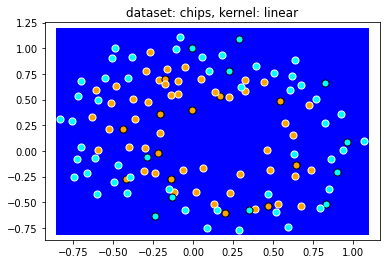

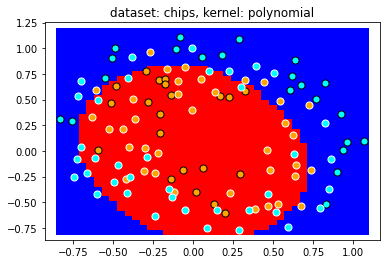

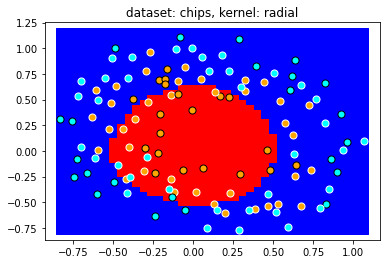

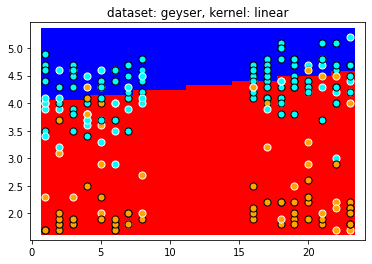

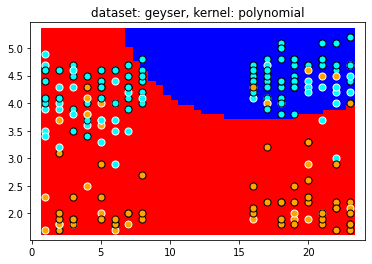

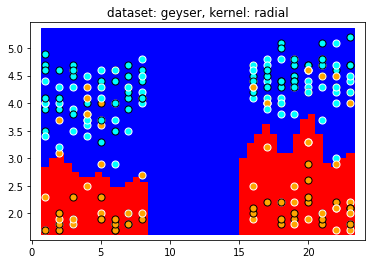

In [25]:
for dataset in ("chips", "geyser"):
    xs = x_chips if dataset == "chips" else x_geyser
    ys = y_chips if dataset == "chips" else y_geyser
    for kernel in ("linear", "polynomial", "radial"):
        if kernel == "linear":
            params = best_params[dataset][linear_kernel]
            plot(
                f"dataset: {dataset}, kernel: {kernel}",
                linear_kernel,
                params, xs, ys)
        elif kernel == "polynomial":
            params = best_params[dataset][polynomial_kernel]
            plot(
                f"dataset: {dataset}, kernel: {kernel}",
                partial(polynomial_kernel, params[1]),
                params[0], xs, ys)
        else:
            params = best_params[dataset][radial_kernel]
            plot(
                f"dataset: {dataset}, kernel: {kernel}",
                partial(radial_kernel, params[1]),
                params[0], xs, ys)
